<h1 align="center">UW CNC Fall Hackathon </h1>  
<h3 align="center"> Dec 4, 2024 </h3>   
<h3 align="center"> mapping mesoscale connectivity between the frontal cortex and thalamus</h3> 
    
    

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
**Overview:** In this notebook, we will analyze thalamic projections to frontal cortex using a 3D light sheet microscopy dataset from whole mouse brains. While this tutorial focuses on thalamocortical connectivity, the dataset contains connections between the frontal cortex and other brain regions, which have yet to be thoroughly explored. 
    
**Dataset:**  This dataset was collected using the mesoscale anatomy platform established at the Allen Institute for Neural Dynamics. Brain samples are cleared and imaged on a SmartSPIM lightsheet microscope. Images are stitched and fused into a 3D volume and aligned to the Common Coordinate Framework (CCF), which allows for integration between samples. Candidate cell somas are algorithmically detected and then classified as true detections or non-cells using a trained deep neural network. This yields a collection of cells throughout the brain, each of which are localized within CCF space. The datasets in this tutorial have been QC'd to verify accurate cell detection, but this verification has been primarily performed in thalamus. Care should be taken to verify cell counts in other regions before drawing strong conclusions. 
    
**Experiment:** These experiments are focused on the structure of inputs to frontal cortex. Retrograde viruses were injected across the frontal cortex, eliciting expression of nuclear-localized fluorophores in infected cells. These injections label somas at the site of virus delivery, as well as the somas of neurons with axonal projections to that location. The brains in this dataset received 1-3 injections of viruses expressing spectrally distinct fluorophores, and thus each injection is conceptualized as an independent connectivity mapping experiment. While the majority of these viral injections employed AAVrg-XFPs, other reagents were also used to address potential cellular or axonal density based tropism. The location of each injection site was empirically determined.
        
    
**Goal:** This tutorial will show you how to:  
    1. analyze connectivity across brain regions  
    2. work with 3D volumetric microscopy data of whole mouse brains 



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #1fa970; ">
MTS: Note for Mathew to remember to include flatmap visualization of injections.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Import packages and load data<br>
    
    

In [1]:
# general imports 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize, ListedColormap

import pandas as pd
%matplotlib inline

In [2]:
# specific imports and brain atlas initialization 

from load_data import load_data
import brainglobe_atlasapi as atlasapi
from brainglobe_atlasapi import BrainGlobeAtlas
atlasapi.config.write_config_value('brainglobe_dir', '/data/.brainglobe') # points to allen mouse atlases pre-loaded in data folder 
atlas = BrainGlobeAtlas('allen_mouse_25um', 
                        check_latest = False) # load CCF mouse brain atlas, 25um resolution 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Load metadata

to do: either in the metadata notebook or here, need to unpack the metadata information  
    find a good dataset to exemplify

In [3]:
metadata_df = pd.read_csv('/scratch/metadata.csv')

metadata_df

,Unnamed: 0,name,subject_id,genotype,sex,virus,titer,ap,ml,dv,volume,age_days,days_to_perfusion,qc_tissue,ng_link,channel,qc_channel,ng_channel,inj_coordinates
0,0,SmartSPIM_678704_2023-06-20_20-49-52_stitched_...,678704,wt/wt,Male,AAVrg-Syn-H2B-Turquoise,4.800000e+13,2.8,1.8,1.0,50.0,45,28,Fail,https://aind-neuroglancer-sauujisjxq-uw.a.run....,445,Fail,NaN,NaN
1,1,SmartSPIM_678704_2023-06-20_20-49-52_stitched_...,678704,wt/wt,Male,AAVrg-Syn-H2B-tdTomato,5.100000e+13,2.4,1.8,0.8,50.0,45,28,Fail,https://aind-neuroglancer-sauujisjxq-uw.a.run....,561,Pending,NaN,NaN
2,2,SmartSPIM_678703_2023-06-20_17-18-27_stitched_...,678703,wt/wt,Male,AAVrg-Syn-H2B-Turquoise,4.800000e+13,1.6,0.2,2.0,50.0,45,28,Fail,https://aind-neuroglancer-sauujisjxq-uw.a.run....,445,Pending,NaN,NaN
3,3,SmartSPIM_678703_2023-06-20_17-18-27_stitched_...,678703,wt/wt,Male,AAVrg-Syn-H2B-tdTomato,5.100000e+13,2.0,0.6,0.6,50.0,45,28,Fail,https://aind-neuroglancer-sauujisjxq-uw.a.run....,561,Pending,NaN,NaN
4,4,SmartSPIM_678706_2023-06-28_16-43-04_stitched_...,678706,wt/wt,Female,AAVrg-Syn-H2B-Turquoise,4.800000e+13,2.8,1.0,1.2,50.0,45,28,Fail,https://aind-neuroglancer-sauujisjxq-uw.a.run....,445,Fail,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,156,SmartSPIM_674182_2023-06-22_13-24-46_stitched_...,674182,wt/wt,Male,AAVrg-Syn-H2B-Turquoise,4.800000e+13,2.4,0.6,1.0,50.0,52,28,Fail,https://aind-neuroglancer-sauujisjxq-uw.a.run....,445,Fail,NaN,NaN
157,157,SmartSPIM_674182_2023-06-22_13-24-46_stitched_...,674182,wt/wt,Male,AAVrg-Syn-H2B-tdTomato,5.100000e+13,2.4,1.0,1.0,50.0,52,28,Fail,https://aind-neuroglancer-sauujisjxq-uw.a.run....,561,Pending,NaN,NaN
158,158,SmartSPIM_693196_2023-09-28_23-12-22_stitched_...,693196,wt/wt,Female,AAVrg-Syn-H2B-Turquoise,2.960000e+14,2.0,1.0,0.6,50.0,52,28,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,445,Fail,https://aind-neuroglancer-sauujisjxq-uw.a.run....,NaN
159,159,SmartSPIM_693196_2023-09-28_23-12-22_stitched_...,693196,wt/wt,Female,AAVrg-Syn-H2B-tdTomato,5.100000e+13,2.4,1.4,1.0,50.0,52,28,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,561,Fail,https://aind-neuroglancer-sauujisjxq-uw.a.run....,NaN


In [20]:
# pick a mouse id brain that passes qc and has multiple channels 
# look at the injection sites (for now, we have targets but soon we'll have actual sites) and see that they are pretty close 
# across the channels. it would be itneresting to compare the variability in the expression across these channels for which 
# the same virus is expressed, similar injection sites, but different titers 
# e.g. 691387

Let's look at one experiment:

In [9]:
metadata_df[metadata_df.subject_id==691387]

,Unnamed: 0,name,subject_id,genotype,sex,virus,titer,ap,ml,dv,volume,age_days,days_to_perfusion,qc_tissue,ng_link,channel,qc_channel,ng_channel,inj_coordinates
153,153,SmartSPIM_691387_2023-09-15_20-47-51_stitched_...,691387,wt/wt,Female,AAVrg-Syn-H2B-Turquoise,2.960000e+14,2.8,1.0,1.2,50.0,45,28,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,445,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,"{'AP': 94, 'ML': 279, 'DV': 117}"
154,154,SmartSPIM_691387_2023-09-15_20-47-51_stitched_...,691387,wt/wt,Female,AAVrg-Syn-H2B-tdTomato,5.100000e+13,2.8,1.8,1.0,50.0,45,28,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,561,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,"{'AP': 103, 'ML': 314, 'DV': 131}"
155,155,SmartSPIM_691387_2023-09-15_20-47-51_stitched_...,691387,wt/wt,Female,AAVrg-Syn-H2B-EGFP,1.360000e+14,2.8,1.4,1.0,50.0,45,28,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,488,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,"{'AP': 103, 'ML': 295, 'DV': 124}"


What do we know about this experiment?

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Load data for a single brain 
      
The load_data object class is a wrapper for pulling relevant lightsheet data and data products from the /data folders for a given mouse ID.  

Here, you can see which channels went through each stage of processing.  
(raw image channels > cell detection model applied > transformation to CCF space)


In [21]:
# mouse_ID = '698035' 
mouse_ID = '691387' 
x = load_data(mouse_ID)

# to do - export the last bit as "channels" to pass through other stuff later on 

Loading data from ../data/SmartSPIM_691387_2023-09-15_20-47-51_stitched_2023-09-20_21-46-54/image_tile_fusing/OMEZarr
Found the following channels: ['445', '488', '561', '639']
Found cell segmentations in the following channels: ['445', '488', '561']
Found CCF aligned quantifications in the following channels: ['445', '488', '561']
Grabbing volumes for level: 3


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #1fa970; ">
MTS: Perhaps it's worth clarifying somewhere that the 639 channel is exclusively used as an autofluorescent channel, whereas all others are signal channels when present. (except in the case of failed injections)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

To do: edit this now that we are visualizing data with neuroglancer 
    
Whole-brain volumes are quite large - each spectral channel is approximately 200 GB in size at full resolution. We can quickly plot compressed versions of the data in different spectral channels using the `plotSlice` function in load_data. 

In [32]:
# Get the neuroglancer links for a given mouse_ID to visualize the data 
# Filter metadata_df for the mouse_ID records and get the ng link.
# would be nice to make the link clickable 

metadata_df[metadata_df.subject_id == int(mouse_ID)].ng_link

'150    https://aind-neuroglancer-sauujisjxq-uw.a.run....\n151    https://aind-neuroglancer-sauujisjxq-uw.a.run....\n152    https://aind-neuroglancer-sauujisjxq-uw.a.run....\nName: ng_link, dtype: object'

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
**Automated Cell Detection**  
    
With this dataset, we can map which brain regions provide input to the frontal cortex. To do so, we need to find all of the cells labelled by each viral injection, and the locations of those cells in the brain. Manually annotating these cells is quite laborious, especially at the whole brain scale. To facilitate quantitative insights from these experiments, cells were automatically detected using machine vision models. The rest of this tutorial will show you how to load and analyze the spatial coordinates of these detected cells. 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

The `getCellsCCFdf` function loads the spatial coordinates of the detected cells in a given channel. Note that these coordinates are transformed into CCF space. 

In [6]:
help(x.getCellsCCFdf)

Help on method getCellsCCFdf in module load_data:

getCellsCCFdf(ch: list) method of load_data.load_data instance
    Retrieves and formats CCF transformed coordinates of segmented cells into a dataframe. 
    
    Parameters
    ----------
    ch : list of str 
        List of imaging channels to retrieve coordinates from (e.g., ["488", "561"]). 
    
    Returns
    -------
    location_df : pd.DataFrame
        Dataframe where each row is a cell and each column is a coordinate: AP (anterior-posterior), DV (dorsal-ventral), or ML (medial-lateral), with an additional "channel" column indicating the channel of origin.



In [5]:
cellLocs = x.getCellsCCFdf(["445", "488", "561"])
cellLocs

,AP,DV,ML,channel
0,248,17,259,445
1,259,15,196,445
2,252,15,202,445
3,250,18,194,445
4,241,19,202,445
...,...,...,...,...
536458,246,276,338,561
536459,256,282,335,561
536460,252,282,333,561
536461,250,279,339,561


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #DFF0D8; ">

**Task 2:** How many cells were detected in each channel? 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

To do: motivate this with a question - compare the expression across the channels given that the injection sites are relatively close together? 
    
Let's explore where the targeted cells are located in the brain. Since this project is focused on mapping thalamocortical connections, we'll take a slice of the brain centered around the thalamus and look at a histogram of the cells targeted in that region. We'll plot in the coronal plane. Using the atlas.get_structure_mask function, we can also overlay the brain structure boundaries to help us identify where the cell targets are. 
    
You can play around with the `plane` and `window` parameters to adjust the location and thickness of the slice we plot or the roiList to outline different brain regions. 

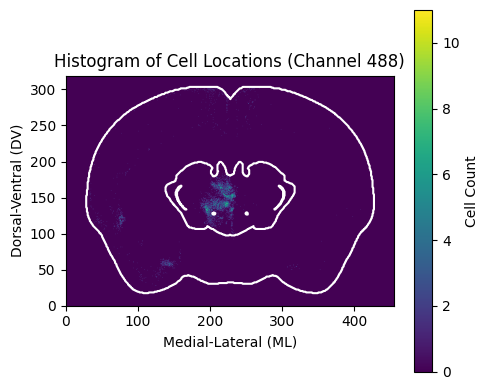

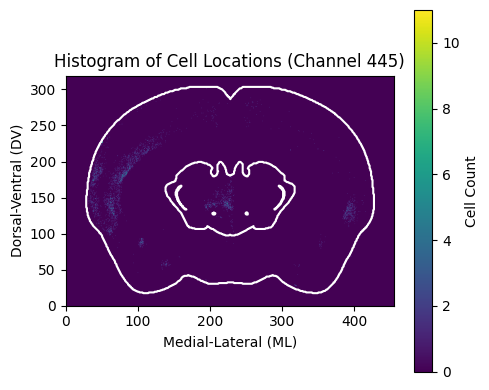

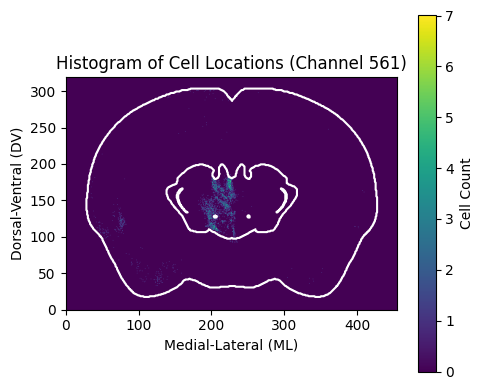

In [8]:
import matplotlib.pyplot as plt
import numpy as np

channel = ["488", "445", "561"]
plane = 250
window = 5
roiList = ["root", "TH"]

# Loop through each channel 
for ch in channel: 
    
    # Set figure parameters 
    fig, ax = plt.subplots(figsize=(5, 4))

    # Generate contour outlines for brain structures
    for roi in roiList:
        roi_mask = atlas.get_structure_mask(roi)
        ax.contour(
            roi_mask[plane, :, :],
            levels=[0.5],
            colors="white",
            linewidths=1.5,
            origin="upper"
        )

    # Generate the histogram of cell coordinates
    planeLocs = cellLocs.loc[
        (cellLocs['AP'] >= plane - window) & (cellLocs['AP'] <= plane + window), :
    ]

    xbins = np.arange(0, atlas.get_structure_mask("root").shape[2], 1)
    ybins = np.arange(0, atlas.get_structure_mask("root").shape[1], 1)
    hist, xedges, yedges = np.histogram2d(
        planeLocs[planeLocs['channel'] == ch]["ML"],
        planeLocs[planeLocs['channel'] == ch]["DV"],
        bins=(xbins, ybins),
    )

    # Overlay the heatmap
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    heatmap = ax.imshow(
        hist.T,  # Transpose because imshow expects (rows, cols)
        extent=extent,
        origin="upper",
        cmap="viridis",
        alpha=1,
    )

    # Add colorbar and labels
    cbar = plt.colorbar(heatmap, ax=ax)
    cbar.set_label("Cell Count")
    ax.set_title(f"Histogram of Cell Locations (Channel {ch})")
    ax.set_xlabel("Medial-Lateral (ML)")
    ax.set_ylabel("Dorsal-Ventral (DV)")

    plt.tight_layout()
    plt.show()


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #1fa970; ">
MTS: These outputs appear to be flipped. Labelling should be on the right side of the brain, rather than the left. This might be an issue with Nick's updating of the datasets - I'll follow up.
    
SJL: this should be fixed when Nick re-runs the datasets this week 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
Focusing on the thalamus, it looks like different injection sites within frontal cortex label different subregions of the thalamus.  

Let's load the cell_count_by_region.csv, which will show us the classified cell counts in each brain structure.  

In [7]:
cell_counts_df = x.getcellcounts(["445", "488", "561"])

to do: unpack cell_counts_df a bit, explain the columns 
make sure to explain that the cell counts within a structure are maintained (thalamus contains counts for thalamus and all descendant structures) 

In [8]:
cell_counts_df

,ID,Acronym,Struct_Info,Struct_area_um3,Left,Right,Total,channel
0,997,root,mid,5.113271e+11,221863,96979,318842,445
1,8,grey,hemi,2.312776e+11,216655,95829,312484,445
2,567,CH,hemi,1.414069e+11,210351,94725,305076,445
3,688,CTX,hemi,1.137573e+11,209884,94508,304392,445
4,695,CTXpl,hemi,1.093212e+11,204495,93524,298019,445
...,...,...,...,...,...,...,...,...
2509,129,V3,mid,1.139386e+09,362,29,391,561
2510,140,AQ,mid,4.506497e+08,0,0,0,561
2511,145,V4,mid,1.372785e+09,0,0,0,561
2512,153,V4r,hemi,3.813698e+08,0,0,0,561


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

To help us assess the connectivity across brain regions, we can use cell_counts_df to construct a connectivity matrix. First, let's filter our dataframe to cells within thalamic subregions. Then, we will use pivot_table to create a connectivity matrix where each row is a channel/injection site, each column is a brain region, and the values are cell counts. 

In [17]:
# thalamic subregions of interest 
roiList = ["MD", "PT", "IAD", "PVT", "IMD", "CM", "PCN", "CL"]

# filter the df for cells within the roiList 
filtered_cell_counts_df = cell_counts_df[cell_counts_df["Acronym"].isin(roiList)] 

# generate connectivity matrix: 
# rows = channels 
# columns = thalamus brain regions 
# values = cell counts 

conn_mat = filtered_cell_counts_df.pivot_table(index = "channel", 
                                      columns = "Acronym", 
                                      values = "Total")
conn_mat

Acronym,CL,CM,IAD,IMD,MD,PCN,PT,PVT
channel,,,,,,,,
445,60,1513,35,192,1044,828,3,169
488,28,859,249,790,1592,21,295,1122
561,79,257,508,147,1037,1,545,2122


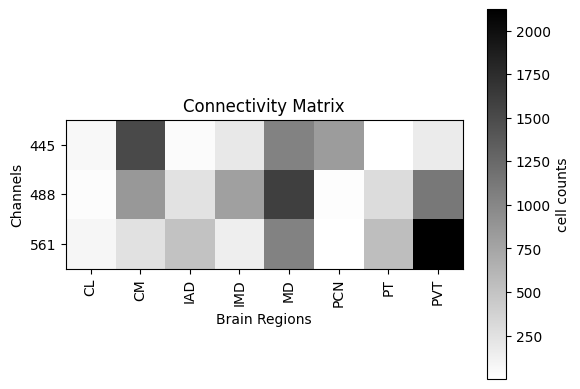

In [18]:
# plot the connectivity matrix as a heatmap 

plt.imshow(conn_mat, cmap="gray_r")
plt.colorbar(label="cell counts")
plt.xticks(ticks=range(len(conn_mat.columns)), labels=conn_mat.columns, rotation=90)
plt.yticks(ticks=range(len(conn_mat.index)), labels=conn_mat.index)
plt.title("Connectivity Matrix")
plt.xlabel("Brain Regions")
plt.ylabel("Channels")
plt.show()

In [19]:
# add a note or task here - instead of comparing raw cell counts, can instead plot density as the structures are variable in size 

In [ ]:
# to do - add some batch processing stuff here 

In [ ]:
# to do - add follow up questions here 
# looking at spatial topography maybe provide some follow up code snippets for attaching brain structure masks to the
# spatial coordinate data frames... (create a separate notebook for this?)

Questions to explore further: 

metadata - can you predict x metadata from y measurement? (e.g. predict injection coordinates from labelled structures) 

tropism - do viruses matter? variability in targeted expression across injection sites 

what is the topography of labelling? 

focus on other parts of brain outside of thalamus (amygdala, cortex, neuromodulatory areas (LC, note that CCF registration bad here)) 

data driven parcellations (NMF, etc...) 

to do: ask Ulises to write some questions 



In [59]:
# thalamic subregions of interest 
roiList = ["MD", "PT", "IAD", "PVT", "IMD", "CM", "PCN", "CL"]

# filter the df for cells within the roiList 
filtered_cellLocs = cellLocs[cellLocs["brain_region"].isin(roiList)] 

# generate connectivity matrix: 
# rows = channels 
# columns = thalamus brain regions 
# values = cell counts 

conn_mat = filtered_cellLocs.pivot_table(index = "channel", 
                                      columns = "brain_region", 
                                      aggfunc = "size", 
                                      fill_value = 0)
conn_mat

brain_region,CL,CM,IAD,IMD,MD,PCN,PT,PVT
channel,,,,,,,,
445,57,1364,34,153,997,754,2,156
488,28,751,225,615,1526,11,259,1046
561,69,178,430,113,914,0,486,1891


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #1fa970; ">
MTS: This is another crack at a cartoon representation of counts in each structure. However the dynamic range gets swamped by the labelling at the injection site. Also there's an inherent bias in these types of plots for larger structures (which can have both more cells, and more false positives)

In [14]:
cell_counts = pd.read_csv(x.quantPaths["561"])

# There's other information here as well, but these counts are in the "Left", "Right" and "Total" column.

cell_counts[cell_counts["Acronym"].isin(["TH", "MD", "PVT", "CTXpl"])] # This dataframe contains a row for each structure in the CCF ontology, 
                                                                       # I'm filtering to just a few structures here

,Unnamed: 0,ID,Acronym,Name,Parent Region,Layer,Ancestors,Graph Order,Id,Struct_Info,Struct_area_um3,Left,Right,Total,Left_Density,Right_Density,Total_Density
4,4,695,CTXpl,Cortical plate,Cerebral cortex,NaN,"['root', 'Basic cell groups and regions', 'Cer...",4,695,hemi,1.093212e+11,40720,9602,50322,3.724804e-07,8.783293e-08,2.301567e-07
410,410,549,TH,Thalamus,Interbrain,NaN,"['root', 'Basic cell groups and regions', 'Bra...",641,549,mid,2.123735e+10,7405,584,7989,6.973563e-07,5.499744e-08,3.761769e-07
453,453,362,MD,Mediodorsal nucleus of thalamus,Interbrain,NaN,"['root', 'Basic cell groups and regions', 'Bra...",685,362,hemi,7.372682e+08,1028,9,1037,1.394336e-06,1.220723e-08,7.032719e-07
457,457,149,PVT,Paraventricular nucleus of the thalamus,Interbrain,NaN,"['root', 'Basic cell groups and regions', 'Bra...",692,149,mid,5.127462e+08,1820,302,2122,7.099028e-06,1.177971e-06,4.138500e-06


In [110]:
# taking an arbitrary slice of the annotation volume here
chosen_slice = 240
structs_in_slice = np.unique(atlas.annotation[chosen_slice,:,:])

# get the acronym for every ID in that slice
# idk brainglobes well enough to know if there is a more efficient way to do this
roiList = [atlas.structures[struct]["acronym"] for struct in structs_in_slice if struct != 0]

# filter the df for cells within the roiList 
filtered_cellLocs = cellLocs[cellLocs["brain_region"].isin(roiList)] 

# generate connectivity matrix: 
# rows = channels 
# columns = thalamus brain regions 
# values = cell counts 

conn_mat = filtered_cellLocs.pivot_table(index = "channel", 
                                      columns = "brain_region", 
                                      aggfunc = "size", 
                                      fill_value = 0)

# Pad with structs for in roiList for which there are no detected cells
for struct in set(roiList) - set(conn_mat.columns):
    conn_mat[struct] = 0
    
conn_mat

brain_region,AAA,ACAd1,ACAd2/3,ACAd5,ACAd6a,ACAd6b,ACAv1,ACAv2/3,ACAv5,ACAv6a,...,st,vhc,SFO,df,PVa,SCH,RCH,SEZ,SBPV,AHN
channel,,,,,,,,,,,,,,,,,,,,,
445,1,35,736,2427,1947,4,0,2,13,29,...,0,0,0,0,0,0,0,0,0,0
488,2,633,4461,3519,544,9,92,1404,2658,337,...,0,0,0,0,0,0,0,0,0,0
561,5,169,772,516,118,1,66,610,1454,295,...,6,0,0,0,0,0,0,0,0,0


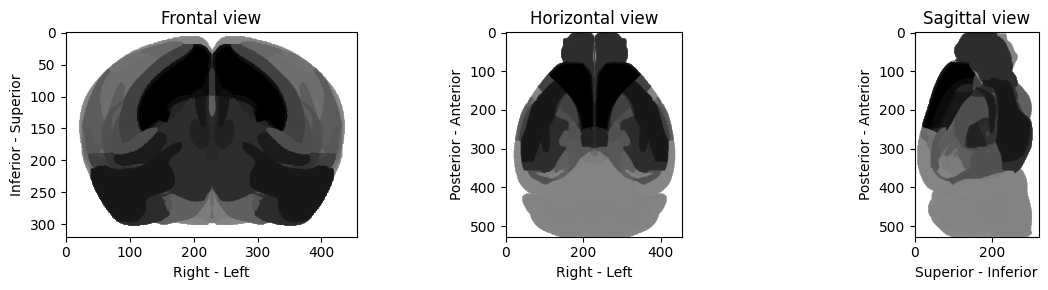

In [112]:
from matplotlib.colors import Normalize

# Generate and combine the masks
mask_combined = atlas.get_structure_mask("root")
mask_combined[mask_combined > 0] = 1  # Initialize root mask with base value (1)
channel = "488"

for i, roi in enumerate(roiList, start=2):
    roi_mask = atlas.get_structure_mask(roi)
    intensity = conn_mat.loc[channel, roi]
    roi_mask[roi_mask > 0] = intensity
    mask_combined += roi_mask

# Plot the results with LogNorm
space = atlas.space
f, axs = plt.subplots(1, 3, figsize=(12, 3))

for i, (plane, labels) in enumerate(zip(space.sections, space.axis_labels)):
    axs[i].imshow(
        mask_combined.max(i), 
        cmap="gray_r", 
        norm=Normalize(vmin=0.1, vmax=mask_combined.max())  # Adjust vmin and vmax
    )
    axs[i].set_title(f"{plane.capitalize()} view")
    axs[i].set_ylabel(labels[0])
    axs[i].set_xlabel(labels[1])

plt.tight_layout()
plt.show()

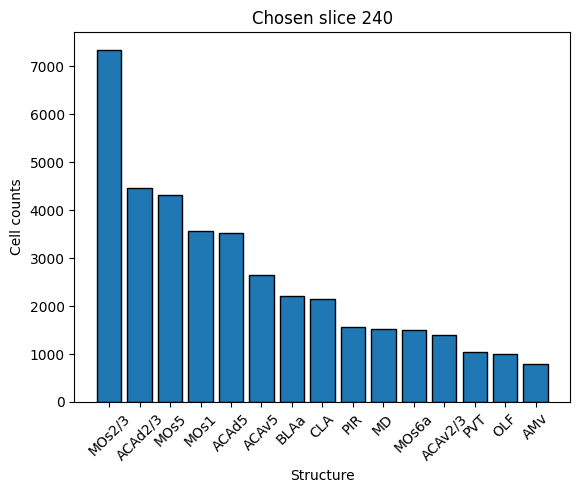

In [170]:

top_n_to_plot = 15
top_structs = conn_mat.T["488"].sort_values(ascending=False).head(top_n_to_plot)
plt.bar(top_structs.index, top_structs, edgecolor = 'k', linewidth = 1)
plt.xticks(rotation=45)
plt.xlabel("Structure")
plt.ylabel("Cell counts")
plt.title("Chosen slice " + str(chosen_slice)); # I added the title to remind myself that this was only looking at 
                                                # the structures within a certain slice, which is a bad way to do it.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #1fa970; ">
MTS: There's probably a way to filter out cortical structures, or filter in only thalamic structures, etc.

In [32]:
# might remove following stuff below this cell

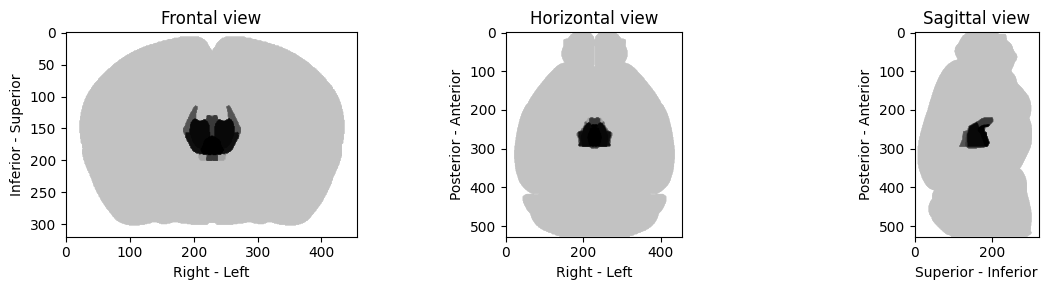

In [19]:
#maybe we don't need this 

from matplotlib.colors import LogNorm

# Generate and combine the masks
mask_combined = atlas.get_structure_mask("root")
mask_combined[mask_combined > 0] = 1  # Initialize root mask with base value (1)
channel = "445"

for i, roi in enumerate(roiList, start=2):
    roi_mask = atlas.get_structure_mask(roi)
    intensity = conn_mat.loc[channel, roi]
    roi_mask[roi_mask > 0] = intensity
    mask_combined += roi_mask

# Plot the results with LogNorm
space = atlas.space
f, axs = plt.subplots(1, 3, figsize=(12, 3))

for i, (plane, labels) in enumerate(zip(space.sections, space.axis_labels)):
    axs[i].imshow(
        mask_combined.max(i), 
        cmap="gray_r", 
        norm=LogNorm(vmin=0.1, vmax=mask_combined.max())  # Adjust vmin and vmax
    )
    axs[i].set_title(f"{plane.capitalize()} view")
    axs[i].set_ylabel(labels[0])
    axs[i].set_xlabel(labels[1])

plt.tight_layout()
plt.show()

In [17]:
roiList = ["MD", "PT", "IAD", "PVT", "IMD", "CM", "PCN", "CL"]

# Define the base mask as the root structure
mask_combined = atlas.get_structure_mask("root")
mask_combined[mask_combined > 0] = 1  # Initialize root mask with a base value (1)

# Assign unique values to each ROI and add them to the combined mask
for i, roi in enumerate(roiList, start = 2):  # Start at 2 to avoid overwriting the root
    roi_mask = atlas.get_structure_mask(roi)
    roi_mask[roi_mask > 0] = i  # Assign a unique value based on index
    mask_combined += roi_mask  # Combine the masks


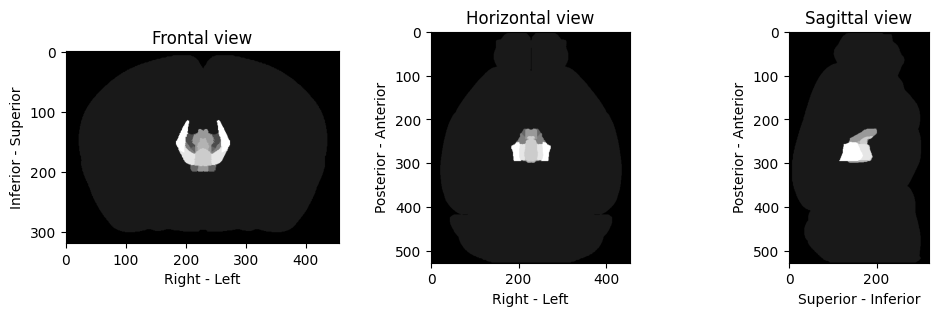

In [18]:
space = atlas.space
f, axs = plt.subplots(1,3, figsize=(12, 3))
for i, (plane, labels) in enumerate(zip(space.sections, space.axis_labels)):
    axs[i].imshow(mask_combined.max(i), cmap="gray")
    axs[i].set_title(f"{plane.capitalize()} view")
    axs[i].set_ylabel(labels[0])
    axs[i].set_xlabel(labels[1])


In [ ]:
# ccfCoordDict = {685903: {'445': [171, 66, 284], '488': [162, 61, 248], '561': [157, 80, 267]},
#                 698035: {'445': [115, 120, 287], '488': [100, 127, 236], '561': [133, 133, 232]},
#                 689238: {'445': [126, 92, 259], '488': [127, 84, 271], '561': [122, 138, 237]},
#                 691387: {'445': [94, 117, 279], '488': [103, 124, 295], '561': [103, 131, 314]},
#                 691388: {'445': [107, 126, 259], '488': [99, 130, 274], '561': [102, 112, 238]},
#                 694512: {'445': [142, 101, 237], '488': [154, 75, 254], '561': [157, 89, 238]},
#                 695721: {'445': [107, 98, 255], '488': [144, 85, 258], '561': [129, 89, 254]},
#                 696668: {'561': [161, 82, 241]},
#                 684812: {'445': [166, 65, 197], '488': [166, 70, 265], '561': [167, 85, 240]},
#                 684821: {'488': [119, 100, 266], '561': [121, 98, 298]},
#                 689237: {'445': [139, 96, 244], '561': [140, 86, 295]},
#                 696669: {'445': [141, 87, 289], '561': [105, 113, 287]},
#                 693977: {'488': [154, 93, 268], '561': [93, 139, 240]},
#                 698927: {'488': [104, 128, 295], '561': [95, 117, 245]},
#                 698928: {'488': [146, 138, 232], '561': [145, 88, 271]},
#                 693979: {'488': [164, 91, 239], '561': [154, 95, 264]},
#                 693980: {'488': [120, 139, 293], '561': [115, 101, 286]},
#                 692909: {'561': [122, 132, 294]},
#                 692907: {'561': [115, 112, 244]},
#                 692912: {'561': [152, 131, 245]},
#                 692911: {'561': [123, 127, 294]},
#                 701750: {'561': [150, 142, 243]},
#                 701751: {'561': [105, 126, 284]},
#                 701754: {'561': [146, 80, 255]},
#                 721832: {'488': [120, 145, 306]}} #manually annotated, estimate injection site later

# virusDict = {685903:'AAVrg-XFP',
#              # 698034:'AAVrg',
#              698035:'AAVrg-XFP',
#              689238:'AAVrg-XFP',
#              691387:'AAVrg-XFP',
#              691388:'AAVrg-XFP',
#              694512:'AAVrg-XFP',
#              695721:'AAVrg-XFP',
#              696668:'AAVrg-XFP',
#              684812:'AAVrg-XFP',
#              684821:'AAVrg-XFP',
#              689237:'AAVrg-XFP',
#              696669:'AAVrg-XFP',
#              693977:"RabV-XFP",
#              698927:"RabV-XFP",
#              698928:"RabV-XFP",
#              693979:"RabV-XFP",
#              693980:"RabV-XFP",
#              692909:"AAVrg-Recombinase",
#              692907:"AAVrg-Recombinase",
#              692912:"AAVrg-Recombinase",
#              692911:"AAVrg-Recombinase",
#              685110:"AAVrg-Recombinase",
#              701750:"RabV-Recombinase",
#              701751:"RabV-Recombinase",
#              701754:"RabV-Recombinase",
#              721832:"AAVrg-XFP"
#             }